In [1]:
from Bio import SeqIO
import pandas as pd
import numpy as np

from genominterv.remapping import remap
from genominterv.remapping import interval_distance, genomic
from genominterv.remapping import remap_interval_data
import seaborn as sns

Load file fasta fiel

In [2]:
import pyBigWig
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm  # optional, for progress bar

file_path = "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/data/macaca/gc5Base_chrX.txt"
import pandas as pd

# Load the file — tab-delimited
df_gc = pd.read_csv(file_path, sep="\t", header=None)

# Name the columns (standard BedGraph format)
df_gc.columns = ["chrom", "start", "end", "value"]

# Show the first few rows
df_gc.head()



,chrom,start,end,value
0,chrX,0,5,80.0
1,chrX,5,10,40.0
2,chrX,10,15,80.0
3,chrX,15,20,40.0
4,chrX,20,25,100.0


## loading eigenvectors using kasper code

In [3]:
def parse_compartment_data(file_name):
    e1_100kb = pd.read_csv(file_name)

    # remove na (experiment)
    e1_100kb.dropna(inplace=True)

    e1_100kb['start'] = [i*100_000 for i in range(e1_100kb.index.size)]
    e1_100kb['end'] = e1_100kb.start + 100_000
    e1_100kb['sign'] = np.sign(e1_100kb.e1)
    e1_100kb['segment_id'] = ((e1_100kb.sign.shift() != e1_100kb.sign)).cumsum()
    
    comp = e1_100kb.groupby('segment_id', as_index=False).agg(dict(
         e1=['mean', 'sum'], 
         start='min', 
         end='max', 
         segment_id='mean', 
         sign='mean'
    ))
    comp.columns = ['_'.join(col).strip() for col in comp.columns.values]
    comp = comp.rename(
        columns={'start_min':'start',
                 'end_max':'end', 
                 'segment_id_mean':'segment_id', 
                 'sign_mean':'sign'}
    )
    comp['comp'] = ['A' if x > 0 else 'B' for x in comp.sign]
    comp = comp.reset_index()
    comp['chrom'] = 'chrX'
    
    _comp = comp.copy()
    for i in range(1, _comp.index.size-1):
        if np.isnan(_comp.loc[i-1, 'e1_mean']):
            _comp.loc[i, 'start'] = np.nan
        if np.isnan(_comp.loc[i+1, 'e1_mean']):
            _comp.loc[i, 'end'] = np.nan
    _comp = _comp.loc[~_comp.e1_mean.isnull(), :]
    _comp = _comp.reset_index()
    compartment_edges = pd.concat([_comp.start, _comp.end]).sort_values().unique()
    
    compartments = comp.loc[~comp.e1_mean.isnull()].copy()
    compartments['start'] = compartments.start.astype(int)
    compartments['end'] = compartments.end.astype(int)

    return compartments, compartment_edges

def edge_segments(compartment_edges, flank):
    compartment_edge_segm = pd.DataFrame(np.column_stack((compartment_edges, compartment_edges+flank)), columns=['start', 'end'])
    compartment_edge_segm['chrom'] = 'chrX'
    return compartment_edge_segm

In [4]:
import os

# Load data
eigentrack_dir = "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/data/eigentracks"
eigentrack_files = [
    f for f in os.listdir(eigentrack_dir) if f.endswith("_10Mb.csv")
]

comps_dict = {}
edges_dict = {}
generated_comps=[]
generated_edges=[]
a_and_b_comps = []

for filename in eigentrack_files:
    filepath = os.path.join(eigentrack_dir, filename)
    base = os.path.splitext(filename)[0]
    comps_var = f"{base}_comps"
    edges_var = f"{base}_edges"
    comps, edges = parse_compartment_data(filepath)
    comps_dict[comps_var] = comps
    edges_dict[edges_var] = edges
    generated_comps.append(comps_var)
    generated_edges.append(edges_var)

print("Generated variable names:", generated_comps)
print("Generated variable names:", generated_edges)

for edge_var in generated_edges:
    # Get the numpy array of edges from the dictionary
    edges = edges_dict[edge_var]
    
    # Create the DataFrame using edge_segments with flank=1
    seg_name = f"{edge_var}_interval"
    seg_df = edge_segments(edges, 1)
    #print(f"Created: {seg_name}")

    # Merge compartment assignment
    comps_var = edge_var.replace("_edges", "_comps")
    if comps_var in comps_dict:
        comps_df = comps_dict[comps_var]
        
        comp_df = pd.DataFrame({
            'comp': comps_df['comp'].reset_index(drop=True),
            'start': seg_df['start'].reset_index(drop=True),
            'end': seg_df['end'].reset_index(drop=True),
            'chrom': seg_df['chrom'].reset_index(drop=True)
        })

        # Save full merged comp_df
        comp_full_name = f"{edge_var}_interval_comp"
            # Save combined A and B compartments
        comp_AB_name = f"{edge_var}_AB"
        globals()[comp_AB_name] = comp_df
        a_and_b_comps.append(comp_AB_name)

        #print(f"Created: {comp_full_name}")

        # Split into compartments A and B
        comp_A = comp_df[comp_df['comp'] == 'A'].reset_index(drop=True)
        comp_B = comp_df[comp_df['comp'] == 'B'].reset_index(drop=True)

        # Save A and B splits as new variables
        comp_A_name = f"{edge_var}_A"
        comp_B_name = f"{edge_var}_B"
        globals()[comp_A_name] = comp_A
        globals()[comp_B_name] = comp_B
        a_and_b_comps.append(comp_A_name)
        a_and_b_comps.append(comp_B_name)
        
        #print(f"Created: {edge_var}_A and {edge_var}_B")

print("Generated compartment A and B variables:", a_and_b_comps)

#print(sperm_e1_100kb_10Mb_edges_A.head())

print(globals()[comp_AB_name].head(30))
print(globals()[comp_AB_name].shape)

Generated variable names: ['sperm_e1_100kb_10Mb_comps', 'round_spermatid_e1_100kb_10Mb_comps', 'pachytene_spermatocyte_e1_100kb_10Mb_comps', 'spermatogonia_e1_100kb_10Mb_comps', 'fibroblast_e1_100kb_10Mb_comps']
Generated variable names: ['sperm_e1_100kb_10Mb_edges', 'round_spermatid_e1_100kb_10Mb_edges', 'pachytene_spermatocyte_e1_100kb_10Mb_edges', 'spermatogonia_e1_100kb_10Mb_edges', 'fibroblast_e1_100kb_10Mb_edges']
Generated compartment A and B variables: ['sperm_e1_100kb_10Mb_edges_AB', 'sperm_e1_100kb_10Mb_edges_A', 'sperm_e1_100kb_10Mb_edges_B', 'round_spermatid_e1_100kb_10Mb_edges_AB', 'round_spermatid_e1_100kb_10Mb_edges_A', 'round_spermatid_e1_100kb_10Mb_edges_B', 'pachytene_spermatocyte_e1_100kb_10Mb_edges_AB', 'pachytene_spermatocyte_e1_100kb_10Mb_edges_A', 'pachytene_spermatocyte_e1_100kb_10Mb_edges_B', 'spermatogonia_e1_100kb_10Mb_edges_AB', 'spermatogonia_e1_100kb_10Mb_edges_A', 'spermatogonia_e1_100kb_10Mb_edges_B', 'fibroblast_e1_100kb_10Mb_edges_AB', 'fibroblast_e1_1

## not nesesary

In [5]:
for edge_var in generated_edges:
    comp_AB_name = f"{edge_var}_AB"
    if comp_AB_name in globals():
        print(f"Head of {comp_AB_name}:")
        print(globals()[comp_AB_name].head())
        print()

Head of sperm_e1_100kb_10Mb_edges_AB:
  comp    start      end chrom
0    A        0        1  chrX
1    B  1700000  1700001  chrX
2    A  7500000  7500001  chrX
3    B  9000000  9000001  chrX
4    A  9200000  9200001  chrX

Head of round_spermatid_e1_100kb_10Mb_edges_AB:
  comp    start      end chrom
0    A        0        1  chrX
1    B  1200000  1200001  chrX
2    A  6700000  6700001  chrX
3    B  6800000  6800001  chrX
4    A  7200000  7200001  chrX

Head of pachytene_spermatocyte_e1_100kb_10Mb_edges_AB:
  comp    start      end chrom
0    A        0        1  chrX
1    B  1100000  1100001  chrX
2    A  7700000  7700001  chrX
3    B  7800000  7800001  chrX
4    A  8500000  8500001  chrX

Head of spermatogonia_e1_100kb_10Mb_edges_AB:
  comp    start      end chrom
0    A        0        1  chrX
1    B  1100000  1100001  chrX
2    A  8400000  8400001  chrX
3    B  8700000  8700001  chrX
4    A  8800000  8800001  chrX

Head of fibroblast_e1_100kb_10Mb_edges_AB:
  comp     start      

## remapping


In [6]:
#     # Clean and sort
# sperm_clean = sperm_e1_100kb_10Mb_edges_AB.dropna(subset=["start", "end"]).copy()
# sperm_clean["start"] = sperm_clean["start"].astype(int)
# sperm_clean["end"] = sperm_clean["end"].astype(int)
# df_gc = df_gc.dropna(subset=["start", "end"]).copy()
# df_gc["start"] = df_gc["start"].astype(int)
# df_gc["end"] = df_gc["end"].astype(int)

# sperm_clean = sperm_clean.sort_values(by=['chrom', 'start', 'end'])
# df_gc = df_gc.sort_values(by=['chrom', 'start', 'end'])

# result = remap_interval_data(df_gc, sperm_clean, include_prox_coord=True)
# # Post-process
# result["mid"] = (result["start"] + result["end"]) / 2
# result["absmid"] = result["mid"].abs()
# result = result.dropna(subset=["start", "end", "mid", "absmid", "start_prox", "end_prox"], how="any")
# result.to_csv("/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/data/macaca/remapping/sperm_e1_100kb_10Mb_edges_AB_gc_remap.txt", sep="\t", index=False)

# print(result.head())

# #print(result["start_prox"].unique())

# GC Content Remapping Script

This script remaps GC content data to genomic edge data for multiple samples and saves the results to text files.

## Steps

1. **Define Input DataFrames**
   A dictionary `df_for_remapping` maps sample names to their corresponding edge DataFrames. These DataFrames contain genomic interval data for compartments A and B.

2. **Clean GC Reference File**
   The GC content DataFrame `df_gc` is cleaned:
   - Rows with missing `start` or `end` values are dropped.
   - Coordinates are cast to integers.
   - Sorted by chromosome and genomic position.

3. **Iterate Over Samples**
   For each sample:
   - The edge DataFrame is cleaned similarly (drop missing values, cast to `int`, sort).
   - GC content is remapped to the edge intervals using the `remap_interval_data` function, with proximal coordinate inclusion.
   - Additional columns (`mid`, `absmid`) are computed to represent the interval midpoint and its absolute value.
   - Rows with missing key values are dropped to ensure a clean result.

4. **Save Output**
   The remapped and post-processed result is saved as a tab-separated `.txt` file in the `remapping/` directory, named according to the sample.

5. **Progress Logging**
   A message is printed for each sample once processing is complete.


In [7]:
# # Define all input edge DataFrames by name
# df_for_remapping = {
#     "sperm_e1_100kb_10Mb_edges_AB": sperm_e1_100kb_10Mb_edges_AB,
#     "round_spermatid_e1_100kb_10Mb_edges_AB": round_spermatid_e1_100kb_10Mb_edges_AB,
#     "pachytene_spermatocyte_e1_100kb_10Mb_edges_AB": pachytene_spermatocyte_e1_100kb_10Mb_edges_AB,
#     "spermatogonia_e1_100kb_10Mb_edges_AB": spermatogonia_e1_100kb_10Mb_edges_AB,
#     "fibroblast_e1_100kb_10Mb_edges_AB": fibroblast_e1_100kb_10Mb_edges_AB
# }

# # Clean the GC reference file once
# df_gc = df_gc.dropna(subset=["start", "end"]).copy()
# df_gc["start"] = df_gc["start"].astype(int)
# df_gc["end"] = df_gc["end"].astype(int)
# df_gc = df_gc.sort_values(by=["chrom", "start", "end"])


# for name, df in df_for_remapping.items():
#     print(f"Processing {name}")
#             # Clean and sort
#     df_clean = df.dropna(subset=["start", "end"]).copy()
#     df_clean["start"] = df_clean["start"].astype(int)
#     df_clean["end"] = df_clean["end"].astype(int)

#     #print(df_clean.head())

#     result = remap_interval_data(df_gc, df_clean, include_prox_coord=True)
#     # Post-process
#     result["mid"] = (result["start"] + result["end"]) / 2
#     result["absmid"] = result["mid"].abs()

#     # Map comp from start_prox using df_clean
#     start_to_comp = df_clean.drop_duplicates(subset=["start"]).set_index("start")["comp"]
#     result["comp"] = result["start_prox"].map(start_to_comp)

#     result = result.dropna(subset=["start", "end", "mid", "absmid", "start_prox", "end_prox"], how="any")
#     result.to_csv(f"/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/data/macaca/remapping/{name}_gc_remap_drop_na.txt", sep="\t", index=False)
#     print(f"{name} done")

# print("finaly done ")

In [8]:
## with out drop.na
# import pandas as pd

# # Load the file into a DataFrame
# file_path1 = "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/data/macaca/remapping/fibroblast_e1_100kb_10Mb_edges_AB_gc_remap.txt"
# fibroblast = pd.read_csv(file_path1, sep="\t")
# print("fibroblast:", fibroblast.shape)
# file_path2 = "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/data/macaca/remapping/sperm_e1_100kb_10Mb_edges_AB_gc_remap.txt"
# sperm = pd.read_csv(file_path2, sep="\t")
# print("sperm:", sperm.shape)
# file_path3 = "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/data/macaca/remapping/round_spermatid_e1_100kb_10Mb_edges_AB_gc_remap.txt"
# round_spermatid = pd.read_csv(file_path3, sep="\t")
# print("round_spermatid:", round_spermatid.shape)
# file_path4 = "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/data/macaca/remapping/pachytene_spermatocyte_e1_100kb_10Mb_edges_AB_gc_remap.txt"
# pachytene_spermatocyte= pd.read_csv(file_path4, sep="\t")
# print("pachytene_spermatocyte:", pachytene_spermatocyte.shape)
# file_path5 = "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/data/macaca/remapping/spermatogonia_e1_100kb_10Mb_edges_AB_gc_remap.txt"
# spermatogonia= pd.read_csv(file_path5, sep="\t")
# print("spermatogonia:", spermatogonia.shape)
# # Display the first few rows
# print(fibroblast.head())


In [9]:
## drop na
import pandas as pd

# Load the file into a DataFrame
file_path1 = "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/data/macaca/remapping/fibroblast_e1_100kb_10Mb_edges_AB_gc_remap_drop_na.txt"
fibroblast = pd.read_csv(file_path1, sep="\t")
print("fibroblast:", fibroblast.shape)

file_path2 = "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/data/macaca/remapping/sperm_e1_100kb_10Mb_edges_AB_gc_remap_drop_na.txt"
sperm = pd.read_csv(file_path2, sep="\t")
print("sperm:", sperm.shape)

file_path3 = "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/data/macaca/remapping/round_spermatid_e1_100kb_10Mb_edges_AB_gc_remap_drop_na.txt"
round_spermatid = pd.read_csv(file_path3, sep="\t")
print("round_spermatid:", round_spermatid.shape)

file_path4 = "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/data/macaca/remapping/pachytene_spermatocyte_e1_100kb_10Mb_edges_AB_gc_remap_drop_na.txt"
pachytene_spermatocyte = pd.read_csv(file_path4, sep="\t")
print("pachytene_spermatocyte:", pachytene_spermatocyte.shape)

file_path5 = "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/data/macaca/remapping/spermatogonia_e1_100kb_10Mb_edges_AB_gc_remap_drop_na.txt"
spermatogonia = pd.read_csv(file_path5, sep="\t")
print("spermatogonia:", spermatogonia.shape)

# Display the first few rows
print(fibroblast.head())


/tmp/ipykernel_1071250/1040939855.py:6: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  fibroblast = pd.read_csv(file_path1, sep="\t")


fibroblast: (21318641, 11)


/tmp/ipykernel_1071250/1040939855.py:10: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  sperm = pd.read_csv(file_path2, sep="\t")


sperm: (20965141, 11)


/tmp/ipykernel_1071250/1040939855.py:14: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  round_spermatid = pd.read_csv(file_path3, sep="\t")


round_spermatid: (20351485, 11)


/tmp/ipykernel_1071250/1040939855.py:18: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  pachytene_spermatocyte = pd.read_csv(file_path4, sep="\t")


pachytene_spermatocyte: (19731508, 11)


/tmp/ipykernel_1071250/1040939855.py:22: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  spermatogonia = pd.read_csv(file_path5, sep="\t")


spermatogonia: (20092109, 11)
   start   end  start_prox  end_prox chrom  start_orig  end_orig  value   mid  \
0    4.0   9.0         0.0       1.0  chrX           5        10   40.0   6.5   
1    9.0  14.0         0.0       1.0  chrX          10        15   80.0  11.5   
2   14.0  19.0         0.0       1.0  chrX          15        20   40.0  16.5   
3   19.0  24.0         0.0       1.0  chrX          20        25  100.0  21.5   
4   24.0  34.0         0.0       1.0  chrX          25        35   80.0  29.0   

   absmid comp  
0     6.5    B  
1    11.5    B  
2    16.5    B  
3    21.5    B  
4    29.0    B  


In [10]:
# import pandas as pd
# import glob
# import os

# # Folder where your data is stored
# data_folder = "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/data/macaca/remapping"

# # Find all files ending with _drop_na.txt
# file_paths = glob.glob(os.path.join(data_folder, "*_drop_na.txt"))

# # Dictionary to store DataFrames with filename (without extension) as keys
# datasets = {}

# for file_path in file_paths:
#     name = os.path.splitext(os.path.basename(file_path))[0]  # filename without extension
#     df = pd.read_csv(file_path, sep="\t")
#     datasets[name] = df
#     print(f"{name}: {df.shape}")

# # Example: Access a specific dataset
# print(datasets[list(datasets.keys())[0]].head())  # first dataset's head




In [11]:
### making the function


'''Step 1
def filter into in A and B compartment:

#seperate into A and B
    A_val = result[
        ((result['comp'] == 'A') & (result['start'] < 0)) |
        ((result['comp'] == 'B') & (result['start'] > 0))
    ].copy()
    B_val = result[
        ((result['comp'] == 'A') & (result['start'] > 0)) |
        ((result['comp'] == 'B') & (result['start'] < 0))
return avarges_A, avarges_B

'''
def filter_into_A_B_compartments(result):
    """
    Splits the input DataFrame into A and B compartments based on sign of 'start' and compartment identity.
    
    Parameters:
        result (pd.DataFrame): Must include columns 'comp' and 'start'.
    
    Returns:
        A_val (pd.DataFrame): Entries where position is consistent with Compartment A.
        B_val (pd.DataFrame): Entries where position is consistent with Compartment B.
    """
    # Entries within A compartment (left of origin if A, right if B)
    A_val = result[
        ((result['comp'] == 'A') & (result['start'] > 0)) |     # is greater than 0
        ((result['comp'] == 'B') & (result['start'] < 0))       # is less than 0
    ].copy()

    # Entries within B compartment (right of origin if A, left if B)
    B_val = result[
        ((result['comp'] == 'A') & (result['start'] < 0)) |     # is less than 0
        ((result['comp'] == 'B') & (result['start'] > 0))       # is greater than 0
    ].copy()

    return A_val, B_val

fibroblast_A, fibroblast_B = filter_into_A_B_compartments(fibroblast)
print(fibroblast_A.head())
print(fibroblast_B.head())





          start       end  start_prox  end_prox chrom  start_orig  end_orig  \
17567  118414.0  118419.0    200000.0  200001.0  chrX      318415    318420   
17568  118419.0  118424.0    200000.0  200001.0  chrX      318420    318425   
17569  118424.0  118429.0    200000.0  200001.0  chrX      318425    318430   
17570  118429.0  118434.0    200000.0  200001.0  chrX      318430    318435   
17571  118434.0  118439.0    200000.0  200001.0  chrX      318435    318440   

       value       mid    absmid comp  
17567   50.0  118416.5  118416.5    A  
17568   60.0  118421.5  118421.5    A  
17569   40.0  118426.5  118426.5    A  
17570   60.0  118431.5  118431.5    A  
17571   80.0  118436.5  118436.5    A  
   start   end  start_prox  end_prox chrom  start_orig  end_orig  value   mid  \
0    4.0   9.0         0.0       1.0  chrX           5        10   40.0   6.5   
1    9.0  14.0         0.0       1.0  chrX          10        15   80.0  11.5   
2   14.0  19.0         0.0       1.0  chrX

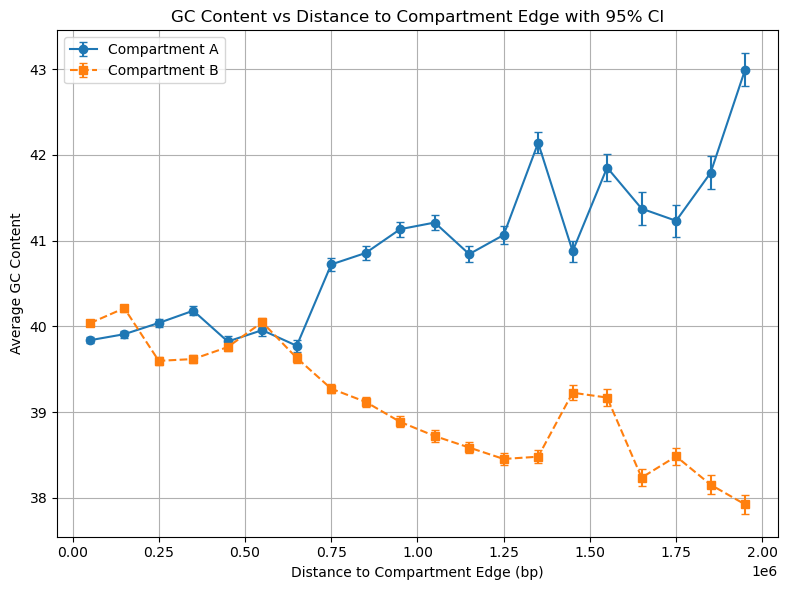

In [12]:
def plot_gc_by_compartment_with_error(A_df, B_df, num_bins=20, max_dist=2_000_000):
    bins = np.linspace(0, max_dist, num_bins + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    def compute_bin_stats(df):
        means = []
        sems = []

        for i in range(len(bins) - 1):
            bin_data = df[(df['absmid'] >= bins[i]) & (df['absmid'] < bins[i + 1])]
            gc_values = bin_data['value'].dropna()

            if len(gc_values) > 0:
                means.append(gc_values.mean())
                sems.append(gc_values.std(ddof=1) / np.sqrt(len(gc_values)))
            else:
                means.append(np.nan)
                sems.append(np.nan)

        means = np.array(means)
        sems = np.array(sems)
        ci_95 = 1.96 * sems  # <- Apply 95% confidence interval here
        return means, ci_95

    # Compute 95% CI for both compartments
    A_means, A_ci = compute_bin_stats(A_df)
    B_means, B_ci = compute_bin_stats(B_df)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.errorbar(bin_centers, A_means, yerr=A_ci, label="Compartment A",
                 marker='o', linestyle='-', capsize=3)
    plt.errorbar(bin_centers, B_means, yerr=B_ci, label="Compartment B",
                 marker='s', linestyle='--', capsize=3)

    plt.xlabel("Distance to Compartment Edge (bp)")
    plt.ylabel("Average GC Content")
    plt.title("GC Content vs Distance to Compartment Edge with 95% CI")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_gc_by_compartment_with_error(fibroblast_A, fibroblast_B)


Compartment A (first 10 cumulative fractions): [0.         0.17241379 0.22413793 0.29310345 0.44827586 0.48275862
 0.55172414 0.60344828 0.65517241 0.72413793]
Compartment B (first 10 cumulative fractions): [0.         0.11864407 0.16949153 0.28813559 0.38983051 0.49152542
 0.52542373 0.54237288 0.61016949 0.6440678 ]
Compartment A (first 10 count): [ 0 10  3  4  9  2  4  3  3  4  4  0  2  3  2  2  2  1  0  0]
Compartment B (first 10 count): [0 7 3 7 6 6 2 1 4 2 3 4 5 4 0 1 2 1 0 1]
Compartment A (first 10 cumulative count): [ 0 10 13 17 26 28 32 35 38 42]


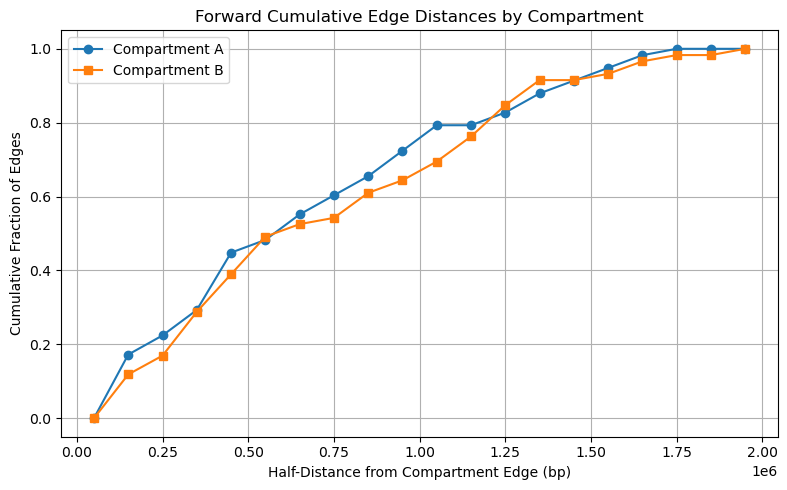

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
max_dist = 2_000_000
num_bins = 20
bin_edges = np.linspace(0, max_dist, num_bins + 1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# --- Function to bin half-distances by compartment ---

def bin_half_distances_by_compartment(comp, max_dist=2_000_000, bins=20):
    bin_edges = np.linspace(0, max_dist, bins + 1)

    results_A = {}
    results_B = {}

    for compartment, result in zip(['A', 'B'], [results_A, results_B]):
        subset = comp[comp['comp'] == compartment]
        start = subset['start'].values

        if len(start) < 2:
            counts = np.zeros(bins, dtype=int)
        else:
            half_distances = [(start[i+1] - start[i]) / 2 for i in range(len(start) - 1)]
            counts, _ = np.histogram(half_distances, bins=bin_edges)

        result["counts"] = counts
        cumulative_count = np.cumsum(counts)
        result["cumulative_count"] = cumulative_count
        result["cumulative_fraction"] = (
            np.cumsum(counts) / np.sum(counts) if np.sum(counts) > 0 else np.zeros(bins)
        )

    return results_A, results_B #, A_uncorected, B_uncorrected

# --- Run the function ---
# Replace this with your actual DataFrame
# Example: edge_df = sperm_e1_100kb_10Mb_edges_AB
edge_df = sperm_e1_100kb_10Mb_edges_AB  # Example

# Get results for A and B
result_A, result_B = bin_half_distances_by_compartment(edge_df)

print("Compartment A (first 10 cumulative fractions):", result_A["cumulative_fraction"][:10])
print("Compartment B (first 10 cumulative fractions):", result_B["cumulative_fraction"][:10])
print("Compartment A (first 10 count):", result_A["counts"])
print("Compartment B (first 10 count):", result_B["counts"])
print("Compartment A (first 10 cumulative count):", result_A["cumulative_count"][:10])


# Plot
plt.figure(figsize=(8, 5))
plt.plot(bin_centers, result_A["cumulative_fraction"], marker='o', label='Compartment A')
plt.plot(bin_centers, result_B["cumulative_fraction"], marker='s', label='Compartment B')


plt.title("Forward Cumulative Edge Distances by Compartment")
plt.xlabel("Half-Distance from Compartment Edge (bp)")
plt.ylabel("Cumulative Fraction of Edges")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

A cum frac (first 10): [0.         0.14705882 0.19117647 0.25       0.38235294 0.41176471
 0.47058824 0.51470588 0.55882353 0.61764706]
B cum frac (first 10): [0.         0.10294118 0.14705882 0.25       0.33823529 0.42647059
 0.45588235 0.47058824 0.52941176 0.55882353]


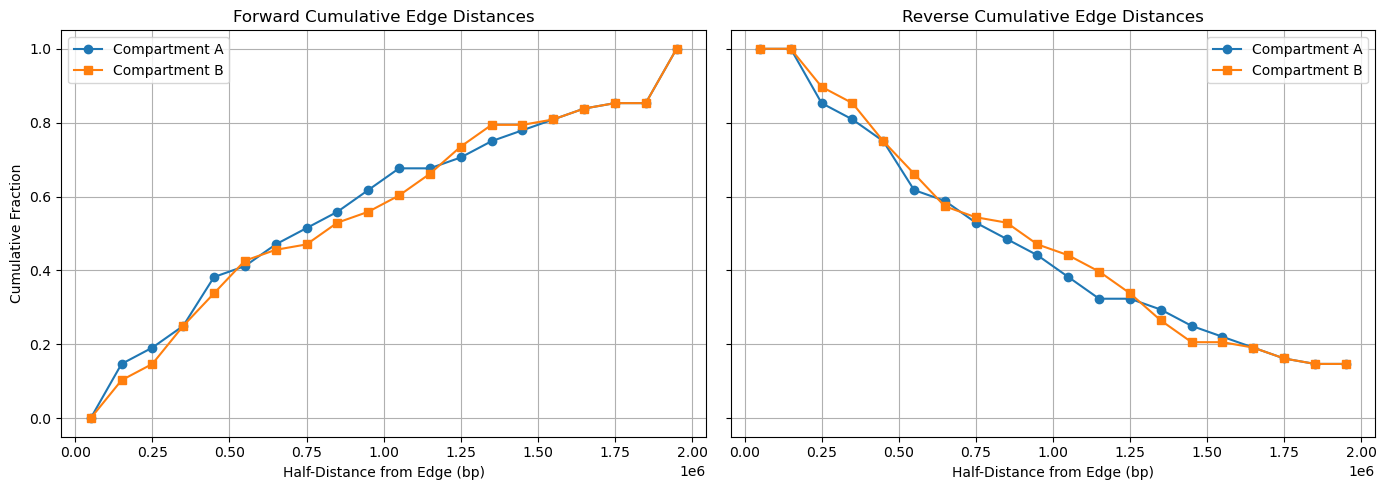

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
max_dist = 2_000_000
num_bins = 20
bin_edges = np.linspace(0, max_dist, num_bins + 1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# --- Function to bin half-distances by compartment ---
def bin_half_distances_by_compartment(comp, max_dist=2_000_000, bins=20):
    bin_edges = np.linspace(0, max_dist, bins + 1)
    results_A, results_B = {}, {}

    for compartment, result in zip(['A', 'B'], [results_A, results_B]):
        subset = comp[comp['comp'] == compartment].copy()

        # Ensure starts are sorted and finite
        start = subset['start'].to_numpy()
        start = start[np.isfinite(start)]
        start = np.sort(start)

        if start.size < 2:
            counts = np.zeros(bins, dtype=int)
        else:
            # Half distances between consecutive starts
            half_distances = (start[1:] - start[:-1]) / 2.0
            # Clip negatives (just in case) and histogram
            half_distances = np.clip(half_distances, 0, max_dist)
            counts, _ = np.histogram(half_distances, bins=bin_edges)

        total = counts.sum()
        cum = np.cumsum(counts)
        rev_cum = np.cumsum(counts[::-1])[::-1]

        result["counts"] = counts
        result["cumulative_count"] = cum
        result["cumulative_fraction"] = (cum / total) if total > 0 else np.zeros(bins)
        result["reverse_cumulative_fraction"] = (rev_cum / total) if total > 0 else np.zeros(bins)

    return results_A, results_B

# --- Run the function ---
edge_df = sperm_e1_100kb_10Mb_edges_AB  # your DataFrame
result_A, result_B = bin_half_distances_by_compartment(edge_df, max_dist=max_dist, bins=num_bins)

# Quick prints (optional)
print("A cum frac (first 10):", result_A["cumulative_fraction"][:10])
print("B cum frac (first 10):", result_B["cumulative_fraction"][:10])

# --- Plot: forward vs reverse cumulative side-by-side ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=True)

# Forward cumulative
axes[0].plot(bin_centers, result_A["cumulative_fraction"], marker='o', label='Compartment A')
axes[0].plot(bin_centers, result_B["cumulative_fraction"], marker='s', label='Compartment B')
axes[0].set_title("Forward Cumulative Edge Distances")
axes[0].set_xlabel("Half-Distance from Edge (bp)")
axes[0].set_ylabel("Cumulative Fraction")
axes[0].grid(True)
axes[0].legend()

# Reverse cumulative (survival)
axes[1].plot(bin_centers, result_A["reverse_cumulative_fraction"], marker='o', label='Compartment A')
axes[1].plot(bin_centers, result_B["reverse_cumulative_fraction"], marker='s', label='Compartment B')
axes[1].set_title("Reverse Cumulative Edge Distances")
axes[1].set_xlabel("Half-Distance from Edge (bp)")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()



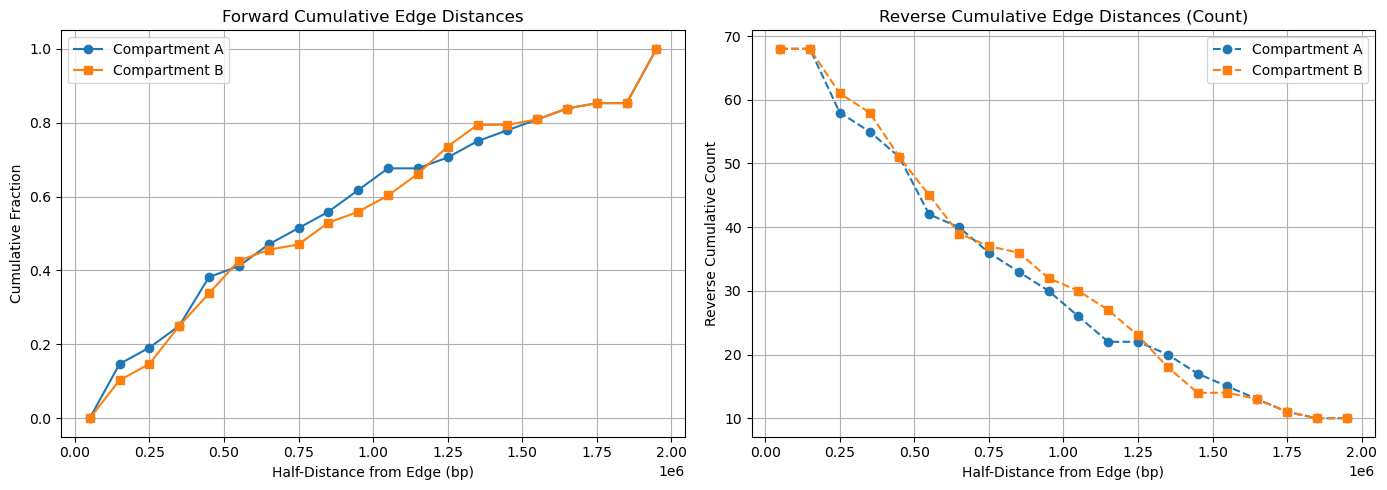

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Reverse cumulative counts
rev_cnt_A = np.cumsum(result_A["counts"][::-1])[::-1]
rev_cnt_B = np.cumsum(result_B["counts"][::-1])[::-1]

# Create 2 side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# --- Plot 1: Forward cumulative fraction ---
axes[0].plot(bin_centers, result_A["cumulative_fraction"], marker='o', label='Compartment A')
axes[0].plot(bin_centers, result_B["cumulative_fraction"], marker='s', label='Compartment B')
axes[0].set_xlabel("Half-Distance from Edge (bp)")
axes[0].set_ylabel("Cumulative Fraction")
axes[0].set_title("Forward Cumulative Edge Distances")
axes[0].grid(True)
axes[0].legend()

# --- Plot 2: Reverse cumulative count ---
axes[1].plot(bin_centers, rev_cnt_A, marker='o', linestyle='--', label='Compartment A')
axes[1].plot(bin_centers, rev_cnt_B, marker='s', linestyle='--', label='Compartment B')
axes[1].set_xlabel("Half-Distance from Edge (bp)")
axes[1].set_ylabel("Reverse Cumulative Count")
axes[1].set_title("Reverse Cumulative Edge Distances (Count)")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.savefig("/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/manuscript/illustrations/edge_distance_plots.png", dpi=300) 
plt.show()



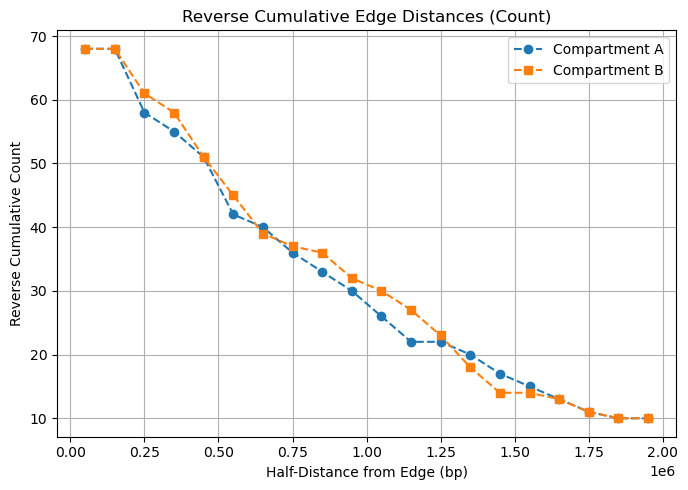

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Reverse cumulative counts
rev_cnt_A = np.cumsum(result_A["counts"][::-1])[::-1]
rev_cnt_B = np.cumsum(result_B["counts"][::-1])[::-1]

# Single plot for reverse cumulative count
plt.figure(figsize=(7, 5))
plt.plot(bin_centers, rev_cnt_A, marker='o', linestyle='--', label='Compartment A')
plt.plot(bin_centers, rev_cnt_B, marker='s', linestyle='--', label='Compartment B')
plt.xlabel("Half-Distance from Edge (bp)")
plt.ylabel("Reverse Cumulative Count")
plt.title("Reverse Cumulative Edge Distances (Count)")
plt.grid(True)
plt.legend()

# Save only this plot
plt.tight_layout()
plt.savefig("/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/manuscript/illustrations/reverse_cumulative_count_v2.png", dpi=300)
# plt.savefig("reverse_cumulative_count.pdf")  # optional vector format
plt.show()

In [14]:
# import numpy as np
# import matplotlib.pyplot as plt

# def plot_gc_by_compartment_with_error(A_df, B_df, num_bins=20, max_dist=2_000_000, return_counts=False):
#     bins = np.linspace(0, max_dist, num_bins + 1)
#     bin_centers = 0.5 * (bins[:-1] + bins[1:])

#     def compute_bin_stats(df):
#         means, sems, counts = [], [], []
#         for i in range(len(bins) - 1):
#             bin_data = df[(df['absmid'] >= bins[i]) & (df['absmid'] < bins[i + 1])]
#             gc_values = bin_data['value'].dropna()
#             n = len(gc_values)
#             counts.append(n)
#             if n > 0:
#                 m = gc_values.mean()
#                 sem = gc_values.std(ddof=1) / np.sqrt(n)
#             else:
#                 m, sem = np.nan, np.nan
#             means.append(m)
#             sems.append(sem)

#         means = np.array(means)
#         ci_95 = 1.96 * np.array(sems)
#         counts = np.array(counts, dtype=int)
#         return means, ci_95, counts

#     A_means, A_ci, A_counts = compute_bin_stats(A_df)
#     B_means, B_ci, B_counts = compute_bin_stats(B_df)

#     # Plot
#     plt.figure(figsize=(8, 6))
#     plt.errorbar(bin_centers, A_means, yerr=A_ci, label="Compartment A",
#                  marker='o', linestyle='-', capsize=3)
#     plt.errorbar(bin_centers, B_means, yerr=B_ci, label="Compartment B",
#                  marker='s', linestyle='--', capsize=3)
#     plt.xlabel("Distance to Compartment Edge (bp)")
#     plt.ylabel("Average GC Content")
#     plt.title("GC Content vs Distance to Compartment Edge (95% CI)")
#     plt.grid(True)
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

#     if return_counts:
#         return {"A_counts": A_counts, "B_counts": B_counts}


In [15]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gc_by_compartment_with_error(ax, df, title, num_bins=20, max_dist=2_000_000):
    # keep only rows within the distance window
    df = df[df['absmid'] <= max_dist].copy()

    bins = np.linspace(0, max_dist, num_bins + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # Optional colors you picked
    deep_green = "#117733"      # deep forest green
    rich_purple = "#7B3294"

    def compute_bin_stats(df_slice):
        means, sems = [], []
        for i in range(len(bins) - 1):
            lo, hi = bins[i], bins[i + 1]
            gc_values = df_slice.loc[(df_slice['absmid'] >= lo) & (df_slice['absmid'] < hi), 'value'].dropna()
            if len(gc_values) > 1:
                sem = gc_values.std(ddof=1) / np.sqrt(len(gc_values))  # SEM
                means.append(gc_values.mean())
                sems.append(1.96 * sem)  # 95% CI
            elif len(gc_values) == 1:
                means.append(gc_values.iloc[0])
                sems.append(np.nan)  # not enough data for CI
            else:
                means.append(np.nan)
                sems.append(np.nan)
        return np.array(means), np.array(sems)

    # Define "A side" vs "B side" relative to the boundary
    A_side = df[((df['comp'] == 'A') & (df['start'] > 0)) |  # right of origin if A
                ((df['comp'] == 'B') & (df['start'] < 0))]  # left of origin if B

    B_side = df[((df['comp'] == 'A') & (df['start'] < 0)) |  # left of origin if A
                ((df['comp'] == 'B') & (df['start'] > 0))]  # right of origin if B



    A_means, A_err = compute_bin_stats(A_side)
    B_means, B_err = compute_bin_stats(B_side)

    ax.errorbar(bin_centers, A_means, yerr=A_err, label="Compartment A", 
                marker='o', linestyle='-', capsize=3, color=deep_green)
    ax.errorbar(bin_centers, B_means, yerr=B_err, label="Compartment B", 
                marker='s', linestyle='--', capsize=3, color=rich_purple)

    ax.set_title(title)
    ax.set_xlabel("Distance to Compartment Edge (bp)")
    ax.set_ylabel("Average GC Content")
    ax.grid(True, alpha=0.3)
    ax.legend()

# # --- usage ---
# fig, axes = plt.subplots(3, 2, figsize=(14, 12))
# axes = axes.flatten()

# datasets = [
#     ("Fibroblast", fibroblast),
#     ("Sperm", sperm),
#     ("Round Spermatid", round_spermatid),
#     ("Pachytene Spermatocyte", pachytene_spermatocyte),
#     ("Spermatogonia", spermatogonia),
# ]

# for i, (label, df) in enumerate(datasets):
#     plot_gc_by_compartment_with_error(axes[i], df, title=label)

# for j in range(len(datasets), len(axes)):
#     axes[j].axis('off')

# plt.tight_layout()
# plt.show()



In [16]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

def bin_half_distances_by_compartment(comp, max_dist=2_000_000, bins=20):
    """Calculate edge availability at each distance - your existing function"""
    bin_edges = np.linspace(0, max_dist, bins + 1)

    results_A = {}
    results_B = {}

    for compartment, result in zip(['A', 'B'], [results_A, results_B]):
        subset = comp[comp['comp'] == compartment]
        start = subset['start'].values

        if len(start) < 2:
            counts = np.zeros(bins, dtype=int)
        else:
            half_distances = [(start[i+1] - start[i]) / 2 for i in range(len(start) - 1)]
            counts, _ = np.histogram(half_distances, bins=bin_edges)

        result["counts"] = counts
        cumulative_count = np.cumsum(counts)
        result["cumulative_count"] = cumulative_count
        result["cumulative_fraction"] = (
            np.cumsum(counts) / np.sum(counts) if np.sum(counts) > 0 else np.zeros(bins)
        )

    return results_A, results_B

def compute_gc_stats_with_edge_weighting(gc_values, bins, cumulative_fraction, use_bootstrap=True, n_bootstrap=1000):
    """
    Compute GC content statistics with edge-weighted error estimation
    
    Parameters:
    - gc_values: array of GC content values with 'absmid' distances
    - bins: distance bins
    - cumulative_fraction: fraction of edges available at each distance
    - use_bootstrap: whether to use bootstrap for error estimation
    """
    
    # Bin the GC values by distance
    bin_means = []
    bin_errors = []
    bin_counts = []
    effective_ns = []
    
    for i in range(len(bins) - 1):
        lo, hi = bins[i], bins[i + 1]
        
        # Get GC values in this distance bin
        mask = (gc_values['absmid'] >= lo) & (gc_values['absmid'] < hi)
        gc_bin_values = gc_values.loc[mask, 'value'].dropna()
        
        n_samples = len(gc_bin_values)
        bin_counts.append(n_samples)
        
        if n_samples == 0:
            bin_means.append(np.nan)
            bin_errors.append(np.nan)
            effective_ns.append(0)
            continue
            
        # Calculate mean GC content
        mean_gc = gc_bin_values.mean()
        bin_means.append(mean_gc)
        
        # Get edge availability for this bin
        edge_fraction = cumulative_fraction[i] if i < len(cumulative_fraction) else 0.01
        edge_fraction = max(edge_fraction, 0.01)  # Avoid division by zero
        
        # Effective sample size considering edge availability
        effective_n = n_samples * edge_fraction
        effective_ns.append(effective_n)
        
        # Error calculation
        if n_samples >= 3 and effective_n >= 1:
            if use_bootstrap and n_samples >= 10:
                # Bootstrap approach for robust error estimation
                bootstrap_means = []
                for _ in range(n_bootstrap):
                    # Resample with replacement, weighted by edge availability
                    boot_sample = np.random.choice(gc_bin_values, 
                                                 size=max(1, int(effective_n)), 
                                                 replace=True)
                    bootstrap_means.append(boot_sample.mean())
                
                # 95% confidence interval from bootstrap
                error = 1.96 * np.std(bootstrap_means)
            else:
                # Traditional SEM with edge weighting
                sem = gc_bin_values.std(ddof=1) / np.sqrt(effective_n)
                error = 1.96 * sem
            
            bin_errors.append(error)
        else:
            bin_errors.append(np.nan)
    
    return np.array(bin_means), np.array(bin_errors), np.array(bin_counts), np.array(effective_ns)

def plot_gc_by_compartment_edge_weighted(ax, df, edge_df, title, num_bins=20, max_dist=2_000_000, 
                                       use_bootstrap=True, min_samples=3):
    """
    Plot GC content with edge-availability-weighted error bars
    """
    
    # Filter data within distance window
    df = df[df['absmid'] <= max_dist].copy()
    
    bins = np.linspace(0, max_dist, num_bins + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    
    # Colors
    deep_green = "#117733"      
    rich_purple = "#7B3294"
    
    # Get edge availability analysis
    result_A, result_B = bin_half_distances_by_compartment(edge_df, max_dist, num_bins)
    
    # Define A and B sides (your existing logic)
    A_side = df[((df['comp'] == 'A') & (df['start'] > 0)) |  
                ((df['comp'] == 'B') & (df['start'] < 0))]  
    
    B_side = df[((df['comp'] == 'A') & (df['start'] < 0)) |  
                ((df['comp'] == 'B') & (df['start'] > 0))]
    
    # Compute statistics with edge weighting
    A_means, A_err, A_counts, A_eff_n = compute_gc_stats_with_edge_weighting(
        A_side, bins, result_A["cumulative_fraction"], use_bootstrap)
    
    B_means, B_err, B_counts, B_eff_n = compute_gc_stats_with_edge_weighting(
        B_side, bins, result_B["cumulative_fraction"], use_bootstrap)
    
    # Plot with conditional error bars
    valid_A = ~np.isnan(A_err) & (A_counts >= min_samples)
    valid_B = ~np.isnan(B_err) & (B_counts >= min_samples)
    
    # Plot points with error bars where valid
    if np.any(valid_A):
        ax.errorbar(bin_centers[valid_A], A_means[valid_A], yerr=A_err[valid_A], 
                    label="Compartment A", marker='o', linestyle='-', capsize=3, 
                    color=deep_green, alpha=0.8)
    
    if np.any(valid_B):
        ax.errorbar(bin_centers[valid_B], B_means[valid_B], yerr=B_err[valid_B], 
                    label="Compartment B", marker='s', linestyle='--', capsize=3, 
                    color=rich_purple, alpha=0.8)
    
    # Plot low-sample points without error bars
    low_A = ~valid_A & ~np.isnan(A_means) & (A_counts > 0)
    low_B = ~valid_B & ~np.isnan(B_means) & (B_counts > 0)
    
    if np.any(low_A):
        ax.scatter(bin_centers[low_A], A_means[low_A], 
                  marker='o', color=deep_green, alpha=0.4, s=30, 
                  label="Compartment A (low n)" if not np.any(valid_A) else "")
    
    if np.any(low_B):
        ax.scatter(bin_centers[low_B], B_means[low_B], 
                  marker='s', color=rich_purple, alpha=0.4, s=30,
                  label="Compartment B (low n)" if not np.any(valid_B) else "")
    
    # Formatting
    ax.set_title(f"{title}\n(Edge-weighted errors, min {min_samples} samples)")
    ax.set_xlabel("Distance to Compartment Edge (bp)")
    ax.set_ylabel("Average GC Content (%)")
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Diagnostics
    method = "bootstrap" if use_bootstrap else "SEM"
    print(f"{title} ({method}): A-side valid bins: {np.sum(valid_A)}/{len(bins)-1}")
    print(f"{title} ({method}): B-side valid bins: {np.sum(valid_B)}/{len(bins)-1}")
    print(f"{title}: Effective N range A: {A_eff_n[A_eff_n>0].min():.1f}-{A_eff_n.max():.1f}")
    print(f"{title}: Effective N range B: {B_eff_n[B_eff_n>0].min():.1f}-{B_eff_n.max():.1f}")

def analyze_gc_datasets_edge_weighted(datasets, edge_datasets, figsize=(14, 12), use_bootstrap=True):
    """
    Main function to analyze multiple GC datasets with edge weighting
    
    Parameters:
    - datasets: list of (name, gc_dataframe) tuples
    - edge_datasets: list of edge dataframes (same order as datasets)
    - use_bootstrap: whether to use bootstrap errors (more robust) vs traditional SEM
    """
    
    fig, axes = plt.subplots(3, 2, figsize=figsize)
    axes = axes.flatten()
    
    for i, (label, df) in enumerate(datasets):
        if i < len(edge_datasets):
            edge_df = edge_datasets[i]
            plot_gc_by_compartment_edge_weighted(
                axes[i], df, edge_df, title=label, 
                use_bootstrap=use_bootstrap,
                min_samples=3
            )
        else:
            axes[i].text(0.5, 0.5, f"No edge data for {label}", 
                        ha='center', va='center', transform=axes[i].transAxes)
    
    # Hide unused subplots
    for j in range(len(datasets), len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    return fig

# Comparison function to show both approaches
def compare_error_methods(df, edge_df, title, figsize=(12, 5)):
    """Compare traditional vs edge-weighted error bars side by side"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Traditional approach (your original)
    from your_original_code import plot_gc_by_compartment_with_error  # Import your original function
    plot_gc_by_compartment_with_error(ax1, df, f"{title}\n(Traditional SEM)")
    
    # Edge-weighted approach
    plot_gc_by_compartment_edge_weighted(ax2, df, edge_df, f"{title}\n(Edge-weighted)", use_bootstrap=True)
    
    plt.tight_layout()
    return fig

# # Usage examples:

# # Main analysis with edge weighting
# datasets = [
#     ("Fibroblast", fibroblast),
#     ("Sperm", sperm), 
#     ("Round Spermatid", round_spermatid),
#     ("Pachytene Spermatocyte", pachytene_spermatocyte),
#     ("Spermatogonia", spermatogonia),
# ]

# edge_datasets = [
#     fibroblast_e1_100kb_10Mb_edges_AB,  # Your edge DataFrames
#     sperm_e1_100kb_10Mb_edges_AB,
#     round_spermatid_e1_100kb_10Mb_edges_AB,
#     pachytene_spermatocyte_e1_100kb_10Mb_edges_AB, 
#     spermatogonia_e1_100kb_10Mb_edges_AB,
# ]



# # Create plots with edge-weighted errors
# fig = analyze_gc_datasets_edge_weighted(datasets, edge_datasets, use_bootstrap=True)
# plt.show()






In [17]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

def bin_half_distances_by_compartment(comp, max_dist=2_000_000, bins=20):
    """Calculate edge availability at each distance - your existing function"""
    bin_edges = np.linspace(0, max_dist, bins + 1)

    results_A = {}
    results_B = {}

    for compartment, result in zip(['A', 'B'], [results_A, results_B]):
        subset = comp[comp['comp'] == compartment]
        start = subset['start'].values

        if len(start) < 2:
            counts = np.zeros(bins, dtype=int)
        else:
            half_distances = [(start[i+1] - start[i]) / 2 for i in range(len(start) - 1)]
            counts, _ = np.histogram(half_distances, bins=bin_edges)

        result["counts"] = counts
        cumulative_count = np.cumsum(counts)
        result["cumulative_count"] = cumulative_count
        result["cumulative_fraction"] = (
            np.cumsum(counts) / np.sum(counts) if np.sum(counts) > 0 else np.zeros(bins)
        )

    return results_A, results_B

def compute_gc_stats_with_edge_weighting(gc_values, bins, cumulative_fraction, use_bootstrap=True, n_bootstrap=1000):
    """
    Compute GC content statistics with edge-weighted error estimation
    
    Parameters:
    - gc_values: array of GC content values with 'absmid' distances
    - bins: distance bins
    - cumulative_fraction: fraction of edges available at each distance
    - use_bootstrap: whether to use bootstrap for error estimation
    """
    
    # Bin the GC values by distance
    bin_means = []
    bin_errors = []
    bin_counts = []
    effective_ns = []
    
    for i in range(len(bins) - 1):
        lo, hi = bins[i], bins[i + 1]
        
        # Get GC values in this distance bin
        mask = (gc_values['absmid'] >= lo) & (gc_values['absmid'] < hi)
        gc_bin_values = gc_values.loc[mask, 'value'].dropna()
        
        n_samples = len(gc_bin_values)
        bin_counts.append(n_samples)
        
        if n_samples == 0:
            bin_means.append(np.nan)
            bin_errors.append(np.nan)
            effective_ns.append(0)
            continue
            
        # Calculate mean GC content
        mean_gc = gc_bin_values.mean()
        bin_means.append(mean_gc)
        
        # Get edge availability for this bin
        edge_fraction = cumulative_fraction[i] if i < len(cumulative_fraction) else 0.01
        edge_fraction = max(edge_fraction, 0.01)  # Avoid division by zero
        
        # Effective sample size considering edge availability
        effective_n = n_samples * edge_fraction
        effective_ns.append(effective_n)
        
        # Error calculation - always compute if we have data
        if n_samples >= 1 and effective_n >= 0.5:
            if use_bootstrap:
                # Bootstrap approach - always use for any sample size when bootstrapping
                bootstrap_means = []
                boot_size = max(1, int(effective_n))
                
                for _ in range(n_bootstrap):
                    # Resample with replacement, weighted by edge availability
                    if n_samples == 1:
                        # For single sample, add some noise to bootstrap
                        boot_sample = np.array([gc_bin_values.iloc[0]])
                    else:
                        boot_sample = np.random.choice(gc_bin_values, 
                                                     size=boot_size, 
                                                     replace=True)
                    bootstrap_means.append(boot_sample.mean())
                
                # 95% confidence interval from bootstrap
                error = 1.96 * np.std(bootstrap_means)
                # Ensure minimum error for single samples
                if n_samples == 1:
                    error = max(error, 0.01)  # Minimum 1% error for single points
            else:
                # Traditional SEM with edge weighting
                if n_samples == 1:
                    error = 0.05  # 5% error for single sample points
                else:
                    sem = gc_bin_values.std(ddof=1) / np.sqrt(effective_n)
                    error = 1.96 * sem
            
            bin_errors.append(error)
        else:
            bin_errors.append(np.nan)
    
    return np.array(bin_means), np.array(bin_errors), np.array(bin_counts), np.array(effective_ns)

def plot_gc_by_compartment_edge_weighted(ax, df, edge_df, title, num_bins=20, max_dist=2_000_000, 
                                       use_bootstrap=True, min_samples=1):
    """
    Plot GC content with edge-availability-weighted error bars
    """
    
    # Filter data within distance window
    df = df[df['absmid'] <= max_dist].copy()
    
    bins = np.linspace(0, max_dist, num_bins + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    
    # Colors
    deep_green = "#117733"      
    rich_purple = "#7B3294"
    
    # Get edge availability analysis
    result_A, result_B = bin_half_distances_by_compartment(edge_df, max_dist, num_bins)
    
    # Define A and B sides (your existing logic)
    A_side = df[((df['comp'] == 'A') & (df['start'] > 0)) |  
                ((df['comp'] == 'B') & (df['start'] < 0))]  
    
    B_side = df[((df['comp'] == 'A') & (df['start'] < 0)) |  
                ((df['comp'] == 'B') & (df['start'] > 0))]
    
    # Compute statistics with edge weighting
    A_means, A_err, A_counts, A_eff_n = compute_gc_stats_with_edge_weighting(
        A_side, bins, result_A["cumulative_fraction"], use_bootstrap)
    
    B_means, B_err, B_counts, B_eff_n = compute_gc_stats_with_edge_weighting(
        B_side, bins, result_B["cumulative_fraction"], use_bootstrap)
    
    # When bootstrapping, show all points with error bars
    if use_bootstrap:
        # All points with data get error bars
        valid_A = ~np.isnan(A_err) & ~np.isnan(A_means) & (A_counts >= min_samples)
        valid_B = ~np.isnan(B_err) & ~np.isnan(B_means) & (B_counts >= min_samples)
        
        # Plot all valid points with error bars
        if np.any(valid_A):
            ax.errorbar(bin_centers[valid_A], A_means[valid_A], yerr=A_err[valid_A], 
                        label="Compartment A", marker='o', linestyle='-', capsize=3, 
                        color=deep_green, alpha=0.8)
        
        if np.any(valid_B):
            ax.errorbar(bin_centers[valid_B], B_means[valid_B], yerr=B_err[valid_B], 
                        label="Compartment B", marker='s', linestyle='--', capsize=3, 
                        color=rich_purple, alpha=0.8)
        
        # Show points without sufficient data as faded dots (no error bars)
        insufficient_A = np.isnan(A_err) & ~np.isnan(A_means) & (A_counts > 0) & (A_counts < min_samples)
        insufficient_B = np.isnan(B_err) & ~np.isnan(B_means) & (B_counts > 0) & (B_counts < min_samples)
        
        if np.any(insufficient_A):
            ax.scatter(bin_centers[insufficient_A], A_means[insufficient_A], 
                      marker='o', color=deep_green, alpha=0.3, s=20)
        
        if np.any(insufficient_B):
            ax.scatter(bin_centers[insufficient_B], B_means[insufficient_B], 
                      marker='s', color=rich_purple, alpha=0.3, s=20)
    
    else:
        # Traditional approach - higher threshold for error bars
        valid_A = ~np.isnan(A_err) & (A_counts >= max(min_samples, 3))
        valid_B = ~np.isnan(B_err) & (B_counts >= max(min_samples, 3))
        
        # Plot points with error bars where valid
        if np.any(valid_A):
            ax.errorbar(bin_centers[valid_A], A_means[valid_A], yerr=A_err[valid_A], 
                        label="Compartment A", marker='o', linestyle='-', capsize=3, 
                        color=deep_green, alpha=0.8)
        
        if np.any(valid_B):
            ax.errorbar(bin_centers[valid_B], B_means[valid_B], yerr=B_err[valid_B], 
                        label="Compartment B", marker='s', linestyle='--', capsize=3, 
                        color=rich_purple, alpha=0.8)
        
        # Plot low-sample points without error bars
        low_A = ~valid_A & ~np.isnan(A_means) & (A_counts > 0)
        low_B = ~valid_B & ~np.isnan(B_means) & (B_counts > 0)
        
        if np.any(low_A):
            ax.scatter(bin_centers[low_A], A_means[low_A], 
                      marker='o', color=deep_green, alpha=0.4, s=30, 
                      label="Compartment A (low n)" if not np.any(valid_A) else "")
        
        if np.any(low_B):
            ax.scatter(bin_centers[low_B], B_means[low_B], 
                      marker='s', color=rich_purple, alpha=0.4, s=30,
                      label="Compartment B (low n)" if not np.any(valid_B) else "")
    
    # Formatting
    ax.set_title(f"{title}\n(Edge-weighted errors, min {min_samples} samples)")
    ax.set_xlabel("Distance to Compartment Edge (bp)")
    ax.set_ylabel("Average GC Content (%)")
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Diagnostics - print ALL datapoints when bootstrapping
    method = "bootstrap" if use_bootstrap else "SEM"
    if use_bootstrap:
        valid_A_count = np.sum(~np.isnan(A_means) & (A_counts >= min_samples))
        valid_B_count = np.sum(~np.isnan(B_means) & (B_counts >= min_samples))
        total_A = np.sum(~np.isnan(A_means) & (A_counts > 0))
        total_B = np.sum(~np.isnan(B_means) & (B_counts > 0))
        
        print(f"\n{title} ({method}):")
        print(f"  A-side: {valid_A_count}/{total_A} bins with error bars ({len(bins)-1} total bins)")
        print(f"  B-side: {valid_B_count}/{total_B} bins with error bars ({len(bins)-1} total bins)")
        print(f"  A-side sample counts per bin: {A_counts[A_counts > 0]}")
        print(f"  B-side sample counts per bin: {B_counts[B_counts > 0]}")
        print(f"  A-side effective N per bin: {A_eff_n[A_eff_n > 0].round(1)}")
        print(f"  B-side effective N per bin: {B_eff_n[B_eff_n > 0].round(1)}")
    else:
        valid_A_count = np.sum(~np.isnan(A_err) & (A_counts >= max(min_samples, 3)))
        valid_B_count = np.sum(~np.isnan(B_err) & (B_counts >= max(min_samples, 3)))
        print(f"{title} ({method}): A-side valid bins: {valid_A_count}/{len(bins)-1}")
        print(f"{title} ({method}): B-side valid bins: {valid_B_count}/{len(bins)-1}")
        print(f"{title}: Effective N range A: {A_eff_n[A_eff_n>0].min():.1f}-{A_eff_n.max():.1f}")
        print(f"{title}: Effective N range B: {B_eff_n[B_eff_n>0].min():.1f}-{B_eff_n.max():.1f}")

def analyze_gc_datasets_edge_weighted(datasets, edge_datasets, figsize=(14, 12), use_bootstrap=True):
    """
    Main function to analyze multiple GC datasets with edge weighting
    
    Parameters:
    - datasets: list of (name, gc_dataframe) tuples
    - edge_datasets: list of edge dataframes (same order as datasets)
    - use_bootstrap: when True, shows ALL data points with error bars and detailed output
    """
    
    fig, axes = plt.subplots(3, 2, figsize=figsize)
    axes = axes.flatten()
    
    for i, (label, df) in enumerate(datasets):
        if i < len(edge_datasets):
            edge_df = edge_datasets[i]
            plot_gc_by_compartment_edge_weighted(
                axes[i], df, edge_df, title=label, 
                use_bootstrap=use_bootstrap,
                min_samples=1  # Always 1 when bootstrapping to show all points
            )
        else:
            axes[i].text(0.5, 0.5, f"No edge data for {label}", 
                        ha='center', va='center', transform=axes[i].transAxes)
    
    # Hide unused subplots
    for j in range(len(datasets), len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    return fig

# Comparison function to show both approaches
def compare_error_methods(df, edge_df, title, figsize=(12, 5)):
    """Compare traditional vs edge-weighted error bars side by side"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Traditional approach (your original)
    from your_original_code import plot_gc_by_compartment_with_error  # Import your original function
    plot_gc_by_compartment_with_error(ax1, df, f"{title}\n(Traditional SEM)")
    
    # Edge-weighted approach
    plot_gc_by_compartment_edge_weighted(ax2, df, edge_df, f"{title}\n(Edge-weighted)", use_bootstrap=True)
    
    plt.tight_layout()
    return fig

# # Usage examples:

# # Main analysis with edge weighting
# datasets = [
#     ("Fibroblast", fibroblast),
#     ("Sperm", sperm), 
#     ("Round Spermatid", round_spermatid),
#     ("Pachytene Spermatocyte", pachytene_spermatocyte),
#     ("Spermatogonia", spermatogonia),
# ]

# edge_datasets = [
#     fibroblast_e1_100kb_10Mb_edges_AB,  # Your edge DataFrames
#     sperm_e1_100kb_10Mb_edges_AB,
#     round_spermatid_e1_100kb_10Mb_edges_AB,
#     pachytene_spermatocyte_e1_100kb_10Mb_edges_AB, 
#     spermatogonia_e1_100kb_10Mb_edges_AB,
# ]

# # Create plots with edge-weighted errors
# fig = analyze_gc_datasets_edge_weighted(datasets, edge_datasets, use_bootstrap=True)
# plt.show()




kode virker med error bar

1.0
1.0
0.9433962264150944
0.8301886792452831
0.7169811320754716
0.6792452830188679
0.5660377358490566
0.4716981132075472
0.4528301886792453
0.41509433962264153
0.39622641509433965
0.2830188679245283
0.2641509433962264
0.24528301886792453
0.20754716981132076
0.16981132075471697
0.11320754716981132
0.03773584905660377
0.03773584905660377
0.018867924528301886
1.0
1.0
0.8823529411764706
0.7647058823529411
0.6862745098039216
0.5882352941176471
0.5490196078431373
0.45098039215686275
0.45098039215686275
0.4117647058823529
0.37254901960784315
0.2549019607843137
0.2549019607843137
0.23529411764705882
0.17647058823529413
0.1568627450980392
0.09803921568627451
0.058823529411764705
0.0196078431372549
0.0196078431372549
1.0
1.0
0.8275862068965517
0.7758620689655172
0.7068965517241379
0.5517241379310345
0.5172413793103449
0.4482758620689655
0.39655172413793105
0.3448275862068966
0.27586206896551724
0.20689655172413793
0.20689655172413793
0.1724137931034483
0.1206896551724138
1.0
1.0
0.8813559322033

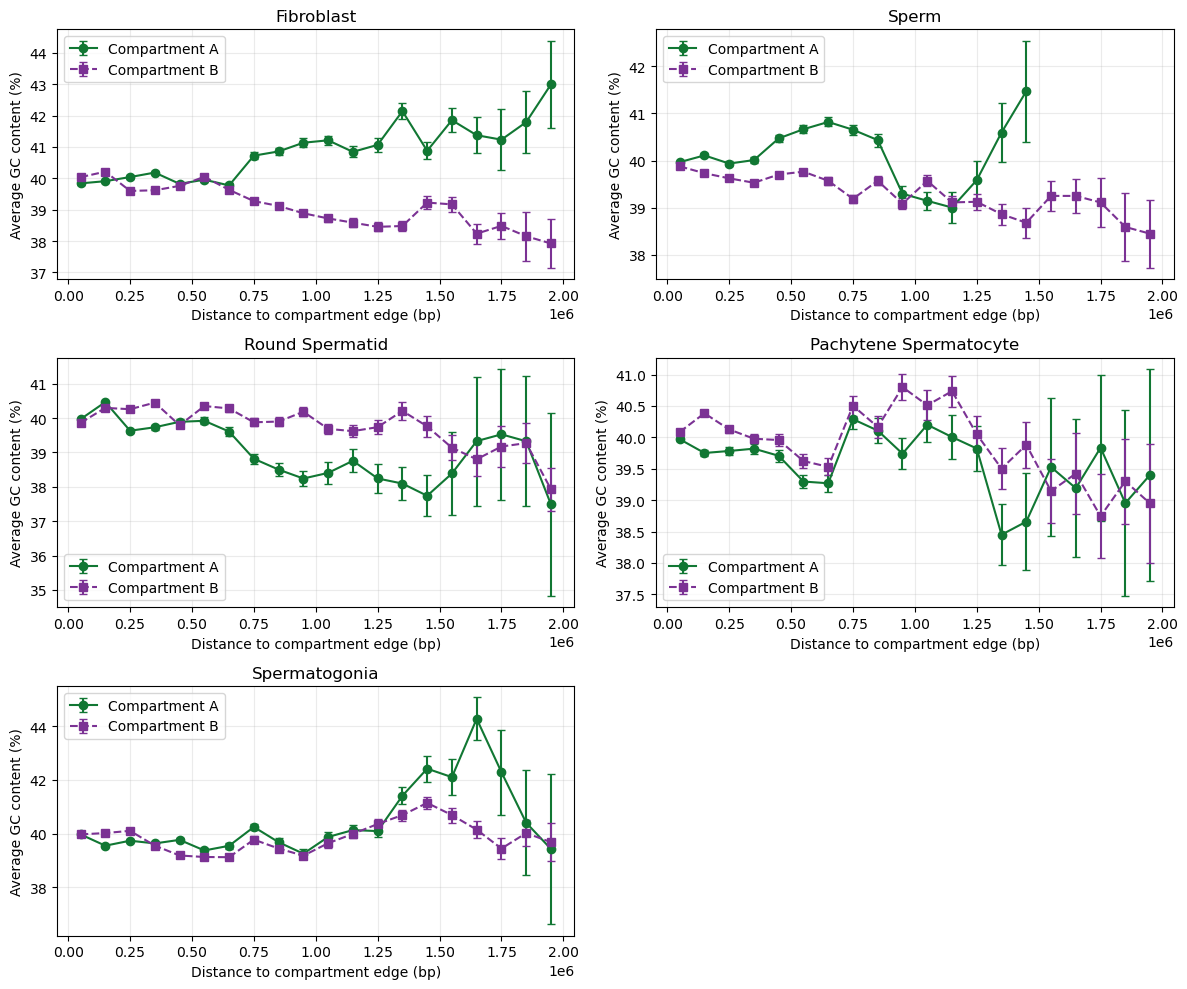

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# --- helpers ---------------------------------------------------------------
A_color = "#117733"  # deep teal
B_color = "#7B3294"  # warm magenta


def _bin_edges(max_dist=2_000_000, bins=20):
    edges = np.linspace(0, max_dist, bins + 1)
    centers = 0.5 * (edges[:-1] + edges[1:])
    return edges, centers

# def _edge_availability(edge_df, max_dist=2_000_000, bins=20):
#     """Return cumulative fraction of available edges per bin for comp A and B."""
#     edges, _ = _bin_edges(max_dist, bins)
#     out = {}
#     for comp in ("A", "B"):
#         starts = edge_df.loc[edge_df["comp"] == comp, "start"].values
#         if starts.size < 2:
#             counts = np.zeros(bins, dtype=int)
#         else:
#             half_d = (starts[1:] - starts[:-1]) / 2.0
#             counts, _ = np.histogram(half_d, bins=edges)
#         cum = counts.cumsum()
#         frac = cum / cum.sum() if cum.sum() else np.zeros_like(cum, dtype=float)
#         out[comp] = frac
#     return out  # {"A": frac, "B": frac}

def _edge_availability(edge_df, max_dist=2_000_000, bins=20):
    """Return reverse cumulative fraction of available edges per bin for comp A and B."""
    edges, _ = _bin_edges(max_dist, bins)
    out = {}
    for comp in ("A", "B"):
        starts = edge_df.loc[edge_df["comp"] == comp, "start"].values
        if starts.size < 2:
            counts = np.zeros(bins, dtype=int)
        else:
            half_d = (starts[1:] - starts[:-1]) / 2.0
            counts, _ = np.histogram(half_d, bins=edges)

        # Reverse cumulative sum
        rev_cum = counts[::-1].cumsum()[::-1]

        # Normalize so bin 0 starts at 1.0 (100% availability)
        frac = rev_cum / rev_cum[0] if rev_cum[0] else np.zeros_like(rev_cum, dtype=float)

        out[comp] = frac
    return out  # {"A": frac, "B": frac}

def _comp_sides(df):
    """Split into A-side and B-side using your sign logic (no changes)."""
    A_side = df[((df['comp'] == 'A') & (df['start'] > 0)) |
                ((df['comp'] == 'B') & (df['start'] < 0))]
    B_side = df[((df['comp'] == 'A') & (df['start'] < 0)) |
                ((df['comp'] == 'B') & (df['start'] > 0))]
    return A_side, B_side

def _bin_stats(gc_df, edges, edge_frac):
    """Mean and 95% CI using SEM, scaled by edge availability as effective N."""
    means = []
    errs  = []
    counts= []
    for lo, hi, f in zip(edges[:-1], edges[1:], edge_frac):
        sel = gc_df[(gc_df["absmid"] >= lo) & (gc_df["absmid"] < hi)]["value"].dropna().to_numpy()
        n = sel.size
        counts.append(n)
        if n == 0:
            means.append(np.nan); errs.append(np.nan); continue
        m = float(sel.mean())
        if n == 1:
            # single-point guardrail: plot point, small default error
            e = 0.05
        else:
            # effective N down-weights sparse edge availability
            eff_n = max(n * max(f, 0.01), 1.0)
            print(f)
            sd = sel.std(ddof=1)
            sem = sd / np.sqrt(eff_n)
            e = 1.96 * sem  # approx 95% CI
        means.append(m); errs.append(e)
    return np.array(means), np.array(errs), np.array(counts)

# --- plotting --------------------------------------------------------------

def plot_gc_by_compartment_simple(ax, df, edge_df, title,
                                  max_dist=2_000_000, bins=20):
    """One clean plot: A/B means with edge-weighted 95% CI error bars."""
    # prep
    df = df.loc[df["absmid"] <= max_dist].copy()
    edges, centers = _bin_edges(max_dist, bins)
    avail = _edge_availability(edge_df, max_dist, bins)
    A_side, B_side = _comp_sides(df)

    # stats
    A_m, A_e, A_n = _bin_stats(A_side, edges, avail["A"])
    B_m, B_e, B_n = _bin_stats(B_side, edges, avail["B"])

    # draw (minimal styling)
    ax.errorbar(centers, A_m, yerr=A_e, marker='o', linestyle='-',
                label='Compartment A', capsize=3, color =A_color)
    ax.errorbar(centers, B_m, yerr=B_e, marker='s', linestyle='--',
                label='Compartment B', capsize=3, color =B_color)

    ax.set_title(title)
    ax.set_xlabel("Distance to compartment edge (bp)")
    ax.set_ylabel("Average GC content (%)")
    ax.grid(True, alpha=0.25)
    ax.legend(loc="best")

    return ax

def plot_many_datasets_simple(datasets, edge_datasets,
                              max_dist=2_000_000, bins=20, ncols=2, figsize=(12, 10)):
    """
    datasets: list of (title, df)
    edge_datasets: list of edge_df (same order)
    """
    n = len(datasets)
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = np.atleast_1d(axes).ravel()

    for i, ((title, df), edge_df) in enumerate(zip(datasets, edge_datasets)):
        plot_gc_by_compartment_simple(axes[i], df, edge_df, title,
                                      max_dist=max_dist, bins=bins)
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    fig.tight_layout()
    return fig


fig = plot_many_datasets_simple(
    datasets=[
        ("Fibroblast", fibroblast),
        ("Sperm", sperm),
        ("Round Spermatid", round_spermatid),
        ("Pachytene Spermatocyte", pachytene_spermatocyte),
        ("Spermatogonia", spermatogonia),
    ],
    edge_datasets=[
        fibroblast_e1_100kb_10Mb_edges_AB,
        sperm_e1_100kb_10Mb_edges_AB,
        round_spermatid_e1_100kb_10Mb_edges_AB,
        pachytene_spermatocyte_e1_100kb_10Mb_edges_AB,
        spermatogonia_e1_100kb_10Mb_edges_AB,
    ],
    bins=20,
    max_dist=2_000_000,
)
plt.show()


check what A and B means in comp
change error bars so when we redo data into bins we calculate error from that bin???
change color depending on data 


in cpg islands chenk conut of edges (kanter)


recombination or ctcf 
find et bedre navn til repository

just for a updata